In [1]:
r"""
    This model primaryly estimates the vertical transport velocity for microplastics
    December 7th, 2021
    Code by Xiangfei Sun, Jinan University

    Please see the associated paper:
    Sun X., Zeng E.Y., Xie M., Mai L., Song X. 
    2022
    Microplastic Deposition in Ocean
    Science
"""

'\n    This model primaryly estimates the vertical transport velocity for microplastics\n    December 7th, 2021\n    Code by Xiangfei Sun, Jinan University\n\n    Please see the associated paper:\n    Sun X., Zeng E.Y., Xie M., Mai L., Song X. \n    2022\n    Microplastic Deposition in Ocean\n    Science\n'

In [2]:
# Functional Package Import
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import copy
import math
import netCDF4
#from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
from pylab import *
import csv
import random
import copy
from scipy.interpolate import make_interp_spline

In [3]:
# Data file reader

# .xlsx reader
def readexcel(file_name):
    
    data = pd.read_excel(file_name)
    train_data = np.array(data)  # np.ndarray()
    excel_list = train_data.tolist()  # list
    
    return excel_list

# .csv reader
def csvimport(file_name):
    
    smiles = []
    with open(file_name,'r',encoding='UTF-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:  
            smiles.append(row)
    smiles[0][0] = 'No.'
    
    return(smiles) 

def csvimport1(file_name):
    
    smiles = []
    with open(file_name) as csvfile:
        csv_reader = csv.reader(csvfile)  
        for row in csv_reader: 
            smiles.append(row)
    smiles[0][0] = 'No.'
    
    return(smiles) 

r"""
   The functions are defined for data import from .csv file (csvimport and csvimport1) 
   and .xlsx file (readexcel)
"""

'\n   The functions are defined for data import from .csv file (csvimport and csvimport1) \n   and .xlsx file (readexcel)\n'

In [4]:
# Random size generator
def exponential_rand(lam):
    if lam <= 0:    
        return -1
    u = random.random()  
    sign = 1
    while sign == 1:
        try:
            value = (-1.0/lam) * np.log(u)  
            sign = 0
        except:
            sign = 1        
    return value

In [81]:
count1 = 0
count2 = 0
record_rad = []
for i in range(1000000):
    new_rad = exponential_rand(6000)
    record_rad.append(new_rad)
    if new_rad <= 0.0005 and new_rad > 0.0001:
        count1 = count1 + 1
    if new_rad <= 0.005 and new_rad > 0.0005:
        count2 = count2 + 1
print(count1,count2)
record_rad = np.array(record_rad)

499003 49951


In [68]:
record_rad

array([0.00125779, 0.00272377, 0.00546343, ..., 0.00211606, 0.00020319,
       0.00067344])

Text(0.5, 1.0, 'My Very Own Histogram')

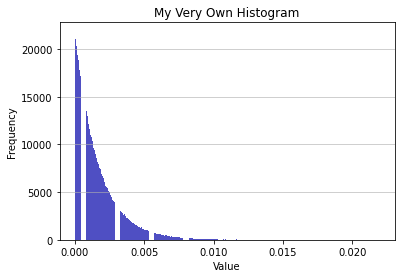

In [69]:
import matplotlib.pyplot as plt
 
# matplotlib.axes.Axes.hist() 方法的接口
n, bins, patches = plt.hist(x=record_rad, bins='auto', color='#0504aa',
    alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')

In [4]:
# Gravity Adjustment according to Latitude
def local_g(lat,depth):
    
    A = 0.0053024
    B = 0.0000058
    C = 3.086e-06
    
    lat_value = float(lat[:-1])
    loc_g = 9.780327*((1+A*(math.sin(lat_value))**2-B*(math.sin(2*lat_value))**2)-C*(-depth))*3600**2*24**2
    
    return(loc_g)
    
    r"""
    Calculates local gravity at given Latitude and water depth.
 
    Parameters
    ----------
    lat : float
        Latitude in degree
    depth : float
        Seawater depth in minus meter
 
    Returns
    -------
    loc_g, the local gravity in m2/day
    
    References
    ----------
    International Gravity Formula, 2008, A Dictionary of Earth Sciences (3 ed.), 
    Oxford University Press.
    """

In [5]:
# Seawater Density according to depth, salinity, and temperature
def water_density(t,S):
    
    c1 = 9.999e02
    c2 = 2.034e-02
    c3 = -6.162e-03
    c4 = 2.261e-05
    c5 = -4.657e-08
    b1 = 8.020e02
    b2 = -2.001
    b3 = 1.677e-02
    b4 = -3.060e-05
    b5 = -1.613e-05
    
    den_f = c1 + c2*t + c3*t**2 + c4*t**3 + c5*t**4 + b1*S + b2*S*t + b3*S*t**2 + b4*S*t**3 + b5*(S**2)*(t**2) 
    value = den_f/1000
    
    return(value)

    r"""
    Calculates seawater density at given temperature and salinity
    using Eq. (8) given by Sharqawy et. al [1]. Values at temperature higher
    than the normal boiling temperature are calculated at the saturation
    pressure.
 
    Parameters
    ----------
    t : float
        Temperature must be in Celsius for this emperical equation to work
 
    S : float
        Salinity must be expressed in kg of salt per kg of solution (ppt).
 
    Returns
    -------
    value, the density of water/seawater in [kg/m3]
 
    Notes
    -----
    T must be in C, and S in g of salt per kg of phase, or ppt (parts per thousand)
    VALIDITY: 0 < T < 180 C; 0 < S < 0.16 kg/kg;
    ACCURACY: 0.1 %
 
    References
    ----------
    [1] Sharqawy M. H., Lienhard J. H., and Zubair, S. M., Desalination and
        Water Treatment, 2010.
    """

In [6]:
# Microplastic Shape, Size, and Weight
# 1. Sphere
def MP_sphere(r_pl):
    
    V_pl = 4*pi*(r_pl**3)/3
    S_pl = 4*pi*(r_pl**2)
    
    return (V_pl, S_pl)
    
    r"""
    Calculates dimensions, sizes, and volume of microplastics in near sphere shape.
    
    Parameters
    ----------
    r_pl : float
        The radius of original microplastic particle near to sphere shape in m.    

    Returns
    -------
    V_pl: float
        The volume of original microplastic particle near to sphere shape in m3.    
    S_pl: float
        The surface area of original microplastic particle near to sphere shape in m2.
    
    Notes
    ----------
    The microplastic particle, which is close to sphere shape, is assumed as a perfect 
    sphere to simplify the analysis. This function can be altered or adjusted for an 
    irregular sphere. However, it may require a simultaneous change for the shape factor 
    estimation according to real-time measurements or modeling assumptions.
    """

# 2. Film:
def MP_film(r_pl,t_pl):
    
    V_pl = pi*(r_pl**2)*t_pl
    S_pl = 2*pi*(r_pl**2) + 2*pi*r_pl*t_pl
    
    return (V_pl, S_pl) 

    r"""
    Calculates dimensions, sizes, and volume of microplastics in film shape.
    
    Parameters
    ----------
    r_pl : float
        The radius of the surface of original microplastic film in m.
    t_pl : float
        The thickness of original microplastic film in m.
        
    Returns
    -------
    V_pl: float
        The volume of original microplastic film in m3.    
    S_pl: float
        The surface area of original microplastic film in m2.
   
    Notes
    ----------
    The microplastic particle, which is close to fibrous shape, is assumed as a perfect 
    long cylinder to simplify the analysis. This function can be altered or adjusted for an 
    irregular or uneven cross-section. However, it may require a simultaneous change for the 
    shape factor estimation according to real-time measurements or modeling assumptions.
    """ 

# 3. Fiber:
def MP_fiber(r_pl,l_pl):
    
    V_pl = pi*(r_pl**2)*l_pl
    S_pl = 4*pi*(r_pl**2) + 2*pi*r_pl*l_pl
    
    return (V_pl, S_pl) 
    
    r"""
    Calculates dimensions, sizes, and volume of microplastics fiber.
    
    Parameters
    ----------
    r_pl : float
        The radius of the cross section of original microplastic fiber in m.
    l_pl : float
        The thickness of original microplastic in film shape in m.
        
    Returns
    -------
    V_pl: float
        The volume of original microplastic fiber in m3.    
    S_pl: float
        The surface area of original microplastic fiber in m2.
    
    Notes
    ----------
    The microplastic particle, which is close to thin film shape, is assumed as an even thickness 
    and a circular shape to simplify the analysis. This function can be altered or adjusted for an 
    irregular or uneven thickness. However, it may require a simultaneous change for the 
    shape factor estimation according to real-time measurements or modeling assumptions.
    """        

In [7]:
# The Enconunter Kernel Rate
def collision(d_ESD,T,k,r_A,w_v,Wt,shear):
    
    # 1 Bronian motion
    D_pl = k*(T+273.16)/(6*pi*w_v*d_ESD*0.5)
    D_A = k*(T+273.16)/(6*pi*w_v*r_A)
    Beta_BM = 4*pi*(D_pl+D_A)*(r_A+d_ESD/2)
    
    # 2 Differential settling
    Beta_DS = 0.5*pi*(0.5*d_ESD)**2*Wt
    
    # 3 Advective shear
    Beta_AS = 1.3*shear*(0.5*d_ESD+r_A)**3
    
    Beta_A = Beta_BM + Beta_DS + Beta_AS
    
    return Beta_A
    
    r"""
    Calculates the particle/algae encounter kernel rate at given temperature, seawater viscosity, 
    veritical speed, and shear using reference [1], [2], and [3]. 
    
    Parameters
    ----------
    T : float
        The seawater temperature at given depth in C.
    k : float
        The Boltzmann constant in m2 kg d-2 K-1.
    w_v : float
        The seawater viscosity at given depth in kg m-1 d-1.
    Wt : float
        The vertical transport speed at given depth in m d-1.
    shear: float
        The shear rate in day-1

    Returns
    -------
    Beta_A: float
        The enconunter kernal rate.
        
    References
    ----------
    [1] Jackson, G. A., A model of the formation of marine algal flocs by physical coagulation processes.
        Deep-Sea Res. I: Oceanogr. Res. 1990, 37, 1197-1211.
    [2] Burd, A. B.; Jackson, G. A., Particle aggregation. Annu. Rev. Mar. Sci. 2009, 1, 65-90.
    [3] Farley, K. J.; Morel, F. M. M., Role of coagulation in the kinetics of sedimentation. Environ. 
        Sci. Technol. 1986, 20, 187-195.
    """

In [8]:
# Selecting parameters for surface Chl_a concentraiton
def position_chl_a(Latitude,Longtiude,Lat_bins,Lon_bins,dataset):
    
    try:
        # Latitude Reposition
        identifier = Latitude[-1]
        lat_value = float(Latitude[:-1])
        if identifier == 'S':
            lat_value = -1*lat_value
        elif identifier == 'N':
            lat_value = lat_value
        else:
            print('The lattitude input is wrong!!')

        # Longtitude Reposition
        identifier = Longtitude[-1]
        lon_value = float(Longtitude[:-1])
        if identifier == 'E':
            lon_value = lon_value
        elif identifier == 'W':
            lon_value = -1*lon_value
        else:
            print('The longtitude input is wrong!!')
        
        posi_lat = np.digitize(lat_value, Lat_bins) - 1
        posi_lon = np.digitize(lon_value, Lon_bins) - 1
        
        chl_a = dataset[posi_lat,posi_lon]
    except:
        print("The given position is on land!  Calculation terminates!")
    
    return(chl_a)

    r"""
    Find the surface Chl_a concentraiton at given latitude and longtitude 
    using reference [1] provided by NASA. 
    
    Parameters
    ----------
    Latitude : string
        The latitude of the given position in degrees and orientation sign.
    Longtitude : string
        The longtitude of the given position in degrees and orientation sign.
    Lat_bins : float
        The latitude of given surface chlorophyll-a profile in degrees.
    Lon_bins : float
        The longtitude of given surface chlorophyll-a profile in degrees.
    dataset: float
        The surface chlorophyll-a concentration matrix in mg m-3.

    Returns
    -------
    chl_a: float
        The surface chlorophyll-a concentration in mg m-3.
        
    References
    ----------
    [1] NASA, Chlorophyll concentration, NASA earth observatory, 
        https://earthobservatory.nasa.gov/global-maps/MY1DMM_CHLORA. 
        (accessed Feb 2, 2022)
    """

In [9]:
# The chlorophyll-a concentration
def Chloro_a(parameter_list, chl_a_bins, chl_a, z):
    
    posi_chl_a = np.digitize(chl_a, chl_a_bins) - 1
    C_b = parameter_list[posi_chl_a][0]
    s = parameter_list[posi_chl_a][1]
    C_max = parameter_list[posi_chl_a][2]
    Z_max = parameter_list[posi_chl_a][3]
    delta_z = parameter_list[posi_chl_a][4]
    dep_eupz = parameter_list[posi_chl_a][9]
    Chl_a_base = parameter_list[posi_chl_a][5]
    Chl_a = (C_b-s*z/dep_eupz+C_max*exp(-((z-Z_max)/delta_z)**2))*Chl_a_base
    if Chl_a < 0:
        Chl_a = 0
    
    return Chl_a

    r"""
    Calculates the chlorophyll-a concentration at given depth based on references [1] and [2].
    
    Parameters
    ----------
    C_b : float
        The normalized surface concentration.
    s : float
        The slope in m-1.
    z: float
        The seawater depth in m.
    C_max: float
        The normalized maximum concentration.
    Z_max: float
        The depth at which the maximum concentration can be found in m.
    delta_z: float
        The width of the peak in m.
    Chl_a_base: float
        The average chlorophyll-a concentration of the vertical profile in mg m-3

    Returns
    -------
    Chl_a: float
        The chlorophyll-a concentration at depth z in mg m-3.
    
    Notes
    ----------
    Chl_a concentration must be a non-negative value.
    
    References
    ----------
    [1] Uitz, J.; Claustre, H.; Morel, A.; Hooker, S. B., Vertical distribution of 
        phytoplankton communities in open ocean: An assessment based on surface chlorophyll.
        J. Geophys. Res. Oceans 2006, 111.
    [2] Ardyna, M.; Babin, M.; Gosselin, M.; Devred, E.; Bélanger, S.; Matsuoka, A.; 
        Tremblay, J. É., Parameterization of vertical chlorophyll a in the Arctic Ocean: 
        Impact of the subsurface chlorophyll maximum on regional, seasonal, and annual primary 
        production estimates. Biogeosciences 2013, 10, 4383-4404.
    """    

In [10]:
# Algae concentraition at given depth z
def algae_c(Chl_a,T,L_z,V_A):
    
    C_conc = Chl_a / (0.003+1.0154*exp(0.05*T)*exp(-0.059*L_z/10**6))
    A_conc = C_conc*10**9 / (0.216*((V_A*10**18)**0.939))
    
    return A_conc,C_conc

    r"""
    Calculates the algae concentration at given depth according to chlorophyll-a concentration
    and carbon ratio given by reference [1] and [2].
    
    Parameters
    ----------
    Chl_a : float
        The vertical chlorophyll-a profile at given depth z in mg m-3.
    T : float
        The temperature at given depth in C.
    L_z : float
        The light intensity at given depth z in (uE m-2 day-1).
    V_A: float
        The algae volume in m3.

    Returns
    -------
    C_conc: float
        The carbon concentration in mg m-3
    A_conc: float
        The algae concentration at given temperature and light intensity L_z in cell m-3.    
    
    References
    ----------
    [1] Cloern, J. E.; Grenz, C.; Vidergar-Lucas, L., An empirical model of the phytoplankton 
        chlorophyll: carbon ratio-the conversion factor between productivity and growth rate. 
        Limnol. Oceanogr. 1995, 40, 1313-1321.
    [2] Menden-Deuer, S.; Lessard, E. J., Carbon to volume relationships for dinoflagellates, 
        diatoms, and other protist plankton. Limnol. Oceanogr. 2000, 45, 569-579.
    """ 

In [11]:
# Light intensity
def light_intensity(z,Chl_a,o_w,o_p,t_ac,I_m,Latitude):
    
    o_t = o_w + o_p * Chl_a
    I_0 = I_m * sin(2*t_ac*pi)
    if I_0 < 0:
        I_0 = 0
    L_z = I_0 * exp(-o_t*z)
    if L_z < 0:
        L_z = 0
        
    return L_z, o_t

    r"""
    Calculates the light intensity at given depth and time based on the law of Lambert-Beer.
    
    Parameters
    ----------
    z : float
        Seawater depth in m.
    Chl_a : float
        The vertical chlorophyll-a profile at given depth z in mg m-3.
    o_w : float
        The extinction coefficients for water.
    o_p : float
        The extinction coefficients for chhlorophyll.
    t: float
        The time spot.
    I_m: float
        The light intensity at noon (uE m-2 day-1)

    Returns
    -------
    L_z: float
        The light intensity at given depth z in (uE m-2 day-1).
    
    """ 

In [12]:
# Algae Growth
def algae_growth(L_z,u_max,I_opt,alpha,T,T_max,T_min,T_opt):
    
    u_opt = u_max*L_z/(L_z+u_max*(L_z/I_opt-1)**2/alpha)
    fy_T = ((T-T_max)*(T-T_min)**2)/((T_opt-T_min)*((T_opt-T_min)*(T-T_opt)-(T_opt-T_max)*(T_opt+T_min-2*T)))
    A_g = u_opt * fy_T
    
    return A_g

    r"""
    Calculates the algae growth rate at given depth and temperature based on reference [1].
    
    Parameters
    ----------
    L_z : float
        The light intensity at given depth z in uE m-2 day-1.
    u_max : float
        The maximum growth rate under optimal conditions in day-1.
    I_opt : float
        The optimal light intensity for algae growth uE m-2 day-1. 
    alpha : float
        The initial slope in day-1.
    T: float
        The temperature at depth z in C.
    T_max: float
        The maximum temperature to sustain algae growth in C.
    T_min: float
        The minimum temperature to sustain algae growth in C.
    T_opt: float
        The optimal temperature to sustain algae growth in C.      

    Returns
    -------
    A_g: float
        The algae growth rate in day-1.
    
    References
    ----------
    [1] Bernard, O.; Rémond, B., Validation of a simple model accounting for light and temperature
        effect on microalgal growth. Bioresour. Technol. 2012, 123, 520-527.
    """ 

In [13]:
# The Biofilm developtment rate
def biofilm_growth(S_pl, A_g, A_conc, Beta_A, m_A, T, Q_10, R_20, A, phy_att):
    
    B_g = Beta_A*A_conc/S_pl*phy_att + A_g*A - m_A*A - Q_10**((T-20)/10)*A*R_20
    
    return B_g   
    
    r"""
    Calculates the biofilm development rate at given depth and temperature.
    
    Parameters
    ----------
    A_g : float
        The algae growth rate in day-1.
    A_conc : float
        The algae concentration at given temperature and light intensity L_z in cell m3.
    S_pl : float
        The surface area of original microplastic film in m2.
    Beta_A : float
        The enconunter kernal rate in m3 day-1.
    m_A: float
        The mortality rate in day-1.
    T: float
        The temperature at depth z in C.
    Q_10: float
        The respiration coefficient.
    R_20: float
        The respiration rate of algae in day-1.
    A: float
        Current algae attached on microplatic surface in cell m-2.

    Returns
    -------
    B_g: float
        The biofilm growth rate in cell m-2 day-1.
    """  

In [14]:
# The biofirm volume
def bio_volume(B_g, V_A, t, A, S_pl):

    A = A + B_g * t
    V_bf = A * V_A * S_pl
        
    return V_bf,A

    r"""
    Calculates the biofilm volume on microplastic at given depth and temperature.
    
    Parameters
    ----------
    V_A : float 
        The volume of single algae in m3. 
    S_pl : float
        The microplastic surface area in m2.
    A : float
        The number of algae in cell m-2.    
    V_M : float
        The volume of minerals on microplastics particle in m3. 
    t: float
        The time length in days.

    Returns
    -------
    V_bf: float
        The accumulated volume of algae in the biofirm in m3.
        
    Notes
    -------
    The algae volume is a non-negative value.
    """ 

In [15]:
# The mineral growth
def minal_volume(Ca_g,L_z,I_m,t,m_b,dep,V_A,A,S_pl):
    
    proj_S_A = A * S_pl * ((3 * V_A / 4 / pi)**(1/3))**2 * pi
    
    # Calcite precipitation caused by photosynthesis
    if proj_S_A < S_pl:
        m_b_ph = 0.5*Ca_g*3600*24*exp(L_z/I_m)/10**6*100/1000*proj_S_A*t
    else:
        m_b_ph = 0.5*Ca_g*3600*24*exp(L_z/I_m)/10**6*100/1000*S_pl*t
        
    # Calcite precipitation caused by passive deposition
    if dep < 3000:
        m_b_pa = 0*3600*24*t*S_pl/10**6*100/1000*t
        
    else:
        m_b_pa = 0
    
    if m_b_ph >= m_b_pa:
        m_b = m_b + m_b_ph
    else:
        m_b = m_b + m_b_pa
    
    # Calcite precipitation based on photosynthesis
    
    V_M = m_b/2630
    
    return m_b, V_M
    
    r"""
    Calculates the calcium precipitation rate on microplastic at given depth based on 
    references [1] -- [4], assuming seafloor is always above the calcite compensation depth.
    
    Parameters
    ----------
    Ca_g : float 
        The calcite precipitation rate in umol m-2 s-1        
    dep : float
        The seawater depth in m.    
    o_t : float
        The coefficient for light reduction. 
    t: float
        The time length in days.
    m_b : float
        The previous mineral build-ups in kg.
    V_A : float
        The algae volume in m3.
    A : float
        Number of algae attached on microplastic surface in No.

    Returns
    -------
    m_b : float
        The accumulated mass of calcite in the biofirm in kg.
    V_M : float
        The voulume current mineral build-ups in m3.  
        
    References
    ----------
    [1] Dong, S.; Subhas, A. V.; Rollins, N. E.; Naviaux, J. D.; Adkins, J. F.; Berelson, 
        W. M., A kinetic pressure effect on calcite dissolution in seawater. Geochim. 
        Cosmochim. Acta 2018, 238, 411-423.
    [2] Šovljanski, O.; Pezo, L.; Tomić, A.; Ranitović, A.; Cvetković, D.; Markov, S., 
        Contribution of bacterial cells as nucleation centers in microbiologically induced 
        CaCO3 precipitation—A mathematical modeling approach. J. Basic Microbiol. 
        2021, 61, 835-848.
    [3] Price, N. N.; Hamilton, S. L.; Smith, J. E.; Tootell, J. S., Species-specific 
        consequences of ocean acidification for the calcareous tropical green algae Halimeda.
        In Mar. Ecol. Prog. Ser., PANGAEA: 2011; Vol. 440, pp 67-78.
    [4] Hartley, A. M.; House Wa Fau - Leadbeater, B. S. C.; Leadbeater Bsc Fau - Callow, M. E.;
        Callow, M. E., The use of microelectrodes to study the precipitation of calcite upon algal 
        biofilms. J. Colloid Interface Sci. 1996, 183, 498-505.
    """ 

In [16]:
# Microplastic volume with included biofilm
def total_volume(V_M, V_bf, V_pl):
    
    V_T = V_pl + V_bf + V_M
    
    return V_T

    r"""
    Calculates the total volume of microplastic inclusion in m3
    
    V_M : float
        The volume of minerals on microplastics particle in m3. 
    V_pl : float
        The microplastic volume in m3.
    V_bf: float
        The volume of biota on microplastic inclusion in m3.
        
    Returns
    -------
    V_T : float
        The total volume of inclusion in m3.
    """

In [17]:
# The equavalent sphaerical diameter
def ESD(V_T):
    
    d_ESD = (3*V_T/(4*pi))**(1/3)*2
    
    return d_ESD

    r"""
    Calculates the equavalent sphaerical diameter (ESD) in m.
    
    Parameters
    ----------
    V_T : float
        The total volume of inclusion in m3.
        
    Returns
    -------
    d_ESD: float
        The equavalent sphaerical diameter (ESD) in m.  
    
    References
    ----------
    [1] Van Melkebeke, M.; Janssen, C.; De Meester, S., Characteristics and sinking behavior of 
        typical microplastics including the potential effect of biofouling: implications for 
        remediation. Environ. Sci. Technol. 2020, 54, 8668-8680.
    [2] Dioguardi, F.; Mele, D.; Dellino, P., A new one-equation model of fluid drag for irregularly 
        shaped particles valid over a wide range of reynolds number. J. Geophys. Res. Solid Earth, 
        2018, 123, 144-156.
    """

In [18]:
# The shape factor
#1. Sphere
def shape_factor_sphere():
    
    X = 1
    Theta = 1
    shape_f = Theta/X
    
    return shape_f

#2. Fiber
def shape_factor_fiber(V_T,l_pl):
    
    r_T = ((V_T/l_pl)/pi)**0.5
    S_p = r_T*2*l_pl*pi + 2*pi*r_T**2
    r_sp = (3*V_T/(4*pi))**(1/3)
    S_sp = 4*pi*r_sp**2
    Theta = S_sp / S_p
    P_p = (r_T*2+l_pl)*2
    S_proj = 2*r_T*l_pl
    r_proj = (S_proj/pi)**0.5
    P_proj = 2*pi*r_proj
    X = P_p/P_proj
    shape_f = Theta/X
    
    return shape_f
    
#3. Film
def shape_factor_film(V_T,r_pl):
    
    t_T = V_T/(pi*r_pl**2)
    S_p = r_pl*2*t_T*pi + 2*pi*r_pl**2
    r_sp = (3*V_T/(4*pi))**(1/3)
    S_sp = 4*pi*r_sp**2
    Theta = S_sp / S_p
    S_proj = r_pl**2*pi*0.5
    r_proj = (S_proj/(pi))**0.5
    P_proj = 2*pi*r_proj
    P_p = 2*pi*r_pl
    X = P_p/P_proj
    shape_f = Theta/X
    
    return shape_f  

    r"""
    Calculates the shape factor of microplastic particle during vertical movement.
    
    Parameters
    ----------
    V_T : float
        The total volume of inclusion in m3.
    l_pl : float
        The length of fiber in m.   
    t_pl : float
        The thickness of film in m.
    
    Returns
    -------
    Theta : float
        The sphericity
    X : float
        The circularity
    shape_f : float
        The shape factor of the inculusion.
        
    Notes
    ----------
    [1] The sphericity is never greater than 1, being 1 for a perfect sphere.
    [2] The circularity is never smaller than 1, being 1 for a perfect circular contour.
    [3] The shape factor is never greater than 1, being 1 for a perfect sphere.
    [4] The shape factor is specifically designed for the vertical velocity calculation 
        formula of Eq. 14 given in reference [1].
    
    References
    ----------
    [1] Dioguardi, F.; Mele, D.; Dellino, P., A new one-equation model of fluid drag for irregularly
        shaped particles valid over a wide range of reynolds number. J. Geophys. Res. Solid Earth, 
        2018, 123, 144-156.
    """

In [19]:
# The microplastic inclusion density
def mp_in_density(V_T,den_pl,den_A,m_b,V_bf,V_pl):
    
    in_den = (V_pl*den_pl + V_bf*den_A + m_b)/V_T
    
    return in_den

    r"""
    Calculates the shape factor of vertical movement.
    
    Parameters
    ----------
    V_T : float
        The total volume of inclusion in m3.
    V_pl : float
        The microplastic volume in m3.
    den_pl : float
        The miroplastic density in kg/m3.
    den_A : float
        The algae density in kg/m3.
    m_b : float
        The accumulated mineral mass in kg.
    V_bf : float
        The current biofilm volume in m3.
    
    Returns
    -------
    in_den : float
        The microplastic inclusion density in kg m-3.
    """

In [20]:
# Seawater Viscosity
def water_viscosity(pore_T,pore_salinity):
    
    T = pore_T
    try:
        S = pore_salinity
    except:
        S = 0
    TC = T
    S = S/1000
    a1 = 1.5700386464E-01
    a2 = 6.4992620050E+01
    a3 = -9.1296496657E+01
    a4 = 4.2844324477E-05
    mu_w = a4 + 1/(a1*(TC+a2)**2+a3)
    a5 = 1.5409136040E+00
    a6 = 1.9981117208E-02
    a7 = -9.5203865864E-05
    a8 = 7.9739318223E+00
    a9 = -7.5614568881E-02
    a10 = 4.7237011074E-04
    A = a5 + a6*T + a7*T**2
    B = a8 + a9*T + a10*T**2
    mu_sw = mu_w*(1 + A*S + B*S**2)
    value = mu_sw * 3600 * 24
    
    return value

    r"""
    Calculates viscosity of pure water or seawater at atmospheric pressure
    using Eq. (22-23) given by Sharqawy et. al [1]. Values at temperature higher
    than the normal boiling temperature are calculated at the saturation
    pressure.
    
    Parameters
    ----------
    pore_temperature : float
        Temperature must be in Celsius for this emperical equation to work 
    pore_salinity : float
        Salinity must be expressed in kg of salt per kg of solution (ppt).
 
    Returns
    -------
    mu_sw, the viscosity of water/seawater in kg m-1 day-1.
 
    Notes
    -----
    T must be in C, and S in g of salt per kg of phase, or ppt (parts per thousand)
    VALIDITY: 0 < T < 180 C; 0 < S < 150 g/kg;
    ACCURACY: 1.5 %
 
    References
    ----------
    [1] Sharqawy M. H., Lienhard J. H., and Zubair, S. M., Desalination and
        Water Treatment, 2010.
    """

In [21]:
# Vertical settlement velocity solver
def vertical_velocity(shape_f,den_f,in_den,g,d_p,u_f):
    
    # Set initial tolerance and guess of Reynolds number for solver
    tolerance = 1
    Re = 100
    
    # Calculating the vertical settlement velocity
    if dep > 0:
        if in_den > den_f:
            while tolerance > 0.01:
                # Update current Reynolds number
                init_Re = Re 
                # Calculating partical drag coefficient using Dioguardi et al., 2018
                Cd = 24/Re*((1-shape_f)/Re+1)**0.25+24/Re*(0.1806*Re**0.6459)/(shape_f**(Re**0.08))+0.4251/(1+6880.95/Re*shape_f**5.05) 
                # Calculating settling velocity
                Wt = (4*g*(in_den-den_f)*d_p/(3*Cd*den_f))**0.5
                # Calculating Reynolds number
                Re = den_f*Wt*d_p/u_f
                # Estimating the new tolerance value under current result
                tolerance = abs(init_Re-Re)/Re
        else:
            while tolerance > 0.01:
                # Update current Reynolds number
                init_Re = Re 
                # Calculating partical drag coefficient using Dioguardi et al., 2018
                Cd = 24/Re*((1-shape_f)/Re+1)**0.25+24/Re*(0.1806*Re**0.6459)/(shape_f**(Re**0.08))+0.4251/(1+6880.95/Re*shape_f**5.05) 
                # Calculating settling velocity
                Wt = (4*g*(den_f-in_den)*d_p/(3*Cd*den_f))**0.5
                # Calculating Reynolds number
                Re = den_f*Wt*d_p/u_f
                # Estimating the new tolerance value under current result
                tolerance = abs(init_Re-Re)/Re
            Wt = -1 * Wt
    else:
        if in_den > den_f:
            while tolerance > 0.01:
                # Update current Reynolds number
                init_Re = Re 
                # Calculating partical drag coefficient using Dioguardi et al., 2018
                Cd = 24/Re*((1-shape_f)/Re+1)**0.25+24/Re*(0.1806*Re**0.6459)/(shape_f**(Re**0.08))+0.4251/(1+6880.95/Re*shape_f**5.05) 
                # Calculating settling velocity
                Wt = (4*g*(in_den-den_f)*d_p/(3*Cd*den_f))**0.5
                # Calculating Reynolds number
                Re = den_f*Wt*d_p/u_f
                # Estimating the new tolerance value under current result
                tolerance = abs(init_Re-Re)/Re
        else:          
            Wt = 0
            Re = Re
            Cd = 0
            
    return(Re, Wt, Cd)

    r"""
    Calculates settling velocity of microplastics with specific density in seawater Eq. (2),(3),(14) 
    given by Dioguardi et al. 2018  
    
    Parameters
    ----------
    shape : float
        The shape factor is a dimensionless parameter to describe the ratio between sphericity and circularity.
    den_f : float 
        The density of seawater in kg m-3.        
    in_den : float
        The density of paricles in kg m-3.       
    g : float
        The gravitational acceleration in m day-2.       
    d_p: float
        The particle size in m.      
    u_f: float
        The seawater viscosity in Pa*day.
    
    Returns
    -------
    Re : float
        The Reynolds number.
    Wt : float
        The particle settling velocity in m day-1.
    Cd : float
        The particle drag coefficient.
 
    Notes
    -----
    R2: 96.0% 
    
    References
    ----------
    [1] Dioguardi, F.; Mele, D.; Dellino, P., A new one-equation model of fluid drag for irregularly
        shaped particles valid over a wide range of reynolds number. J. Geophys. Res. Solid Earth, 
        2018, 123, 144-156.
    [2] Van Melkebeke, M.; Janssen, C.; De Meester, S., Characteristics and sinking behavior of typical 
        microplastics including the potential effect of biofouling: implications for remediation. 
        Environ. Sci. Technol. 2020, 54, 8668-8680.
    """

In [22]:
def cal_given_posi(Latitude,Longtiude,date,tolerance):
    
    # Latitude Reposition
    identifier = Latitude[-1]
    lat_value = float(Latitude[:-1])
    if identifier == 'S':
        lat_value = -1*lat_value
    elif identifier == 'N':
        lat_value = lat_value
    else:
        print('The lattitude input is wrong!!')

    # Longtitude Reposition
    identifier = Longtitude[-1]
    lon_value = float(Longtitude[:-1])
    if identifier == 'E':
        if lon_value > 74.16:
            lon_value = lon_value
        else:
            lon_value = lon_value + 360
    elif identifier == 'W':
        lon_value = 360 - lon_value
    else:
        print('The longtitude input is wrong!!')
           
    # Data import
    url = 'F:\RTOFS\Original_data\\' + date + '_rtofs_glo_3dz_n024_daily_3ztio.nc'
    file = netCDF4.Dataset(url)
    lat  = file.variables['Latitude'][:]
    lon  = file.variables['Longitude'][:]
    dep = file.variables['Depth'][:]
    file.close()
    
    for i in range(3298):
        for j in range(4500):
            lat_diff = abs(lat[i,j] - lat_value)
            lon_diff = abs(lon[i,j] - lon_value)
            new_diff = (lat_diff**2 + lon_diff**2)**0.5
            if new_diff < tolerance:
                posi_lat = i
                posi_lon = j
            else:
                continue
                
    # Data import
    url = 'F:\RTOFS\Original_data\\' + date + '_rtofs_glo_3dz_n024_daily_3ztio.nc'
    file = netCDF4.Dataset(url)

    # Extract data from given location
    temp = file.variables['temperature'][0,:,posi_lat,posi_lon]
    file.close()

    # Data import
    url = 'F:\RTOFS\Original_data\\' + date + '_rtofs_glo_3dz_n024_daily_3zsio.nc'
    file = netCDF4.Dataset(url)

    # Extract data from given location
    sat = file.variables['salinity'][0,:,posi_lat,posi_lon]
    file.close()

    Sea_den = []
    for i in range(len(sat)):
        try:
            new_point = water_density(temp.data[i],sat.data[i]/1000)
            if new_point > 0 and new_point < 1.2:
                Sea_den.append(new_point)
            else:
                continue
        except:
            continue
    Sea_den = np.array(Sea_den)    
    
    return(Sea_den,sat,temp)

    r"""
    Localize the given latitude and longtitude on the RTOFS datasets and extract the vertical profiles of 
    seawater temperature and salinity at given date. Calculate the seawater density profiles accordingly.
    
    Parameters
    ----------
    Latitude : string
        The proposed Latitude in degrees with orientation.
    Longtitude : string
        The proposed Longtiude in degrees with orientation.
    date : float
        The proposed date.       
    tolerance : float
        The difference between proposed location and avaliable data points. 
    
    Returns
    -------
    Sea_den : float
        The vertical seawater density at given location in kg m-3.
    sat : float
        The vertical seawater salinity at given location in ppt.
    temp : float
        The vertical seawater temperature at given location in C.
    """

In [23]:
# Density, Salinity and Temperature at given depth
def position(dep,bins,Sea_den,sat,temp):
    
    posi_depth = max_depth_check(sat) - 1
    max_depth = bins[posi_depth]
    if dep < max_depth:
        cats = np.digitize(dep, bins)
        posi_den = Sea_den[cats] - (Sea_den[cats] - Sea_den[cats-1])/(bins[cats] - bins[cats-1])*(bins[cats]-dep)
        posi_sat = sat[cats] - (sat[cats] - sat[cats-1])/(bins[cats] - bins[cats-1])*(bins[cats]-dep)
        posi_temp = temp[cats] - (temp[cats] - temp[cats-1])/(bins[cats] - bins[cats-1])*(bins[cats]-dep)
        sign = 0
    else:
        sign = 0
        #print("The maximum depth is apporached, which is: " + str(max_depth) + 'm at given location.')
        posi_den = Sea_den[posi_depth]
        posi_sat = sat[posi_depth]
        posi_temp = temp[posi_depth]
        dep = max_depth
        
    return(sign, posi_den, posi_sat, posi_temp, dep)

    r"""
    Calculate density, sanlinity, and temperature at given depth with last known position and vertical settling velocity.
    
    Parameters
    ----------
    dep : float
        The current depth in m.
    Sea_den : float
        The vertical profiles of seawater density in kg m-3.
    sat : float
        The vertical profiles of seawater salinity in ppt.   
    temp : float
        The vertical profiles of seawater temperature in ppt.
    bins : float
        The given depth in m.
    
    Returns
    -------
    sign : float
        The value which indicates whether the particle approaches the seafloor.
    posi_den : float
        The surrounding seawater density at given depth in m.
    posi_temp : float
        The surrounding seawater temperature at given depth in C.
    posi_sat : float
        The surrounding seawater salinity at given depth in ppt.
    dep : float
        The fixed depth in m.
    
    Notes
    -------
    The depth never excceds the maximum avaliable seawater depth at given location.
    """

In [24]:
# Check maximum depth at given locaiton
def max_depth_check(sat):
    
    count = 0
    for i in range(len(sat.data)):
        if sat.data[i] < 1.2676506e+30:
            count = count + 1
        else:
            break
            
    return count

    r"""
    Estimate the maximum seawater depth at given location.
    """

In [25]:
def evaluation_same_volume(r_pl,t_pl,l_pl):
    # Given the same size with different shape
    V_pl = 4/3*pi*r_pl**3
    r_fiber = (V_pl/l_pl/pi)**0.5
    r_film = (V_pl/t_pl/pi)**0.5
    return(r_fiber,r_film)

In [26]:
# Positioning
date = '20211208'
# California
Latitude = '36.8N'
Longtitude = '122.35W'
# SY-1
#Latitude = '13.5N'
#Longtitude = '87.3E'
# SA
#Latitude = '34.650S'
#Longtitude = '18.717E'
# North Atlantic
#Latitude = '45.60N'
#Longtitude = '15.19W'

tolerance = 0.08
Sea_den,sat,temp = cal_given_posi(Latitude,Longtitude,date,tolerance)

In [27]:
Sea_den

array([1.02485184, 1.0249159 , 1.02499857, 1.02528979, 1.02560015,
       1.02586439, 1.02605356, 1.02619707, 1.02632491, 1.0264195 ,
       1.02651711, 1.02659267, 1.02673497, 1.02692728, 1.02701236,
       1.02707745, 1.02712597, 1.02717367, 1.02724879])

In [28]:
# Surface chlorophyll-a database import
chl_a_file_name = r"C:\Users\JePhyllis\MP_Vertical_Transport_Model\Chl_a_surface concentration.csv"
chl_a_file = csvimport(chl_a_file_name)
chl_a_file = np.array(chl_a_file)
Lon_bins = chl_a_file[0,1:]
Lat_bins = chl_a_file[1:,0]
Lat_bins = Lat_bins.astype('float')
Lon_bins = Lon_bins.astype('float')
dataset = chl_a_file[1:,1:].astype('float')

chl_a_cal_file_name = r'C:\Users\JePhyllis\MP_Vertical_Transport_Model\chl_a_parameter.xlsx'
chl_a_cal = readexcel(chl_a_cal_file_name)
chl_a_cal = np.array(chl_a_cal)
parameter_list = chl_a_cal

In [131]:
path1 = r'E:\暨南大学\碳排放与碳中和\Proposal\Biofouling\Paper\Test Results\Trajectory\\'

In [167]:
# Plastic Material Properties
shape_type = 'film'
Lat = float(Latitude[:-1])
r_pl = 0.00005
l_pl = 0.001
t_pl = 0.00001
den_pl = 960

#HDPE
Ca_g = 0.2
phy_att = 0.5
#LDPE
#Ca_g = 0.1
#phy_att = 0.2

#l_pl = 0.001
#r_fiber = 0.0005
#r_film = 0.01
if shape_type == 'fiber':
    r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
elif shape_type == 'film':
    r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
#r_pl = (exponential_rand(5.5)*1000+100)*0.000001*0.5
#l_pl = random.randrange(57,13000)*0.000001
#t_pl = random.randrange(10,50)*0.000001

den_A = 1380
V_A = 1e-15
m_A = 0.39
R_20 = 0.1
k = 1.0306e-013
Q_10 = 2
u_max = 1.85
alpha = 0.12
T_min = 0.2
T_opt = 26.7
T_max = 33.3
I_opt = 1.75392e13
t = 0.02
o_w = 0.2
o_p = 0.02
I_m = 1.2e08
bins = np.array([0.,10.,20.,30.,50.,75.,100.,125.,150.,200.,250.,300.,400.,500.,600.,700.,800.,900.,1000.,1100.,
                 1200.,1300.,1400.,1500.,1750.,2000.,2500.,3000.,3500.,4000.,4500.,5000.,5500.])
shear = 1.7e05
r_A = (3*V_A/(4*pi))**(1/3)
chl_a_bins = np.array([0,0.04,0.08,0.12,0.2,0.3,0.4,0.8,2.2,4])

dep = 0
m_b = 0
W_t = 0

if shape_type == 'sphere':
    V_pl, S_pl = MP_sphere(r_pl)
    V_T = V_pl
    #shape_f = shape_factor_sphere()
    shape_f = 1
elif shape_type == 'fiber':
    V_pl, S_pl = MP_fiber(r_fiber,l_pl)
    V_T = V_pl
    shape_f = shape_factor_fiber(V_T,l_pl)   
elif shape_type == 'film':
    V_pl, S_pl = MP_film(r_film,t_pl)
    V_T = V_pl
    shape_f = shape_factor_film(V_T,r_pl)  
V_bf = 0
V_M = 0
d_ESD = ESD(V_T)
sign, posi_den, posi_sat, posi_temp, dep = position(dep,bins,Sea_den,sat.data,temp.data)
w_v = water_viscosity(posi_temp,posi_sat)
Beta_A = collision(d_ESD,posi_temp,k,r_A,w_v,W_t,shear)
A = 0
sign = 0
t_total = 0
t_ac = 0
count_mark = 0
dep_record = []
time_lenth = 100
round_sim = int(time_lenth/t)
print('The initial shape factor of given plastic particle is: '+str(shape_f)+'.' )

while sign == 0 and t_total < round_sim:
    sign, posi_den, posi_sat, posi_temp, dep = position(dep,bins,Sea_den,sat.data,temp.data)
    chl_a = position_chl_a(Latitude,Longtitude,Lat_bins,Lon_bins,dataset)
    if chl_a > 4:
        chl_a = 3.9
    Chl_a = Chloro_a(parameter_list, chl_a_bins, chl_a, dep)
    L_z, o_t = light_intensity(dep,Chl_a,o_w,o_p,t_ac,I_m,Lat)
    A_conc,C_conc = algae_c(Chl_a,posi_temp,L_z,V_A)
    A_g = algae_growth(L_z,u_max,I_opt,alpha,posi_temp,T_max,T_min,T_opt)
    w_v = water_viscosity(posi_temp,posi_sat)
    Beta_A = collision(d_ESD,posi_temp,k,r_A,w_v,W_t,shear)
    B_g = biofilm_growth(S_pl, A_g, A_conc, Beta_A, m_A, posi_temp, Q_10, R_20, A, phy_att)
    m_b, V_M = minal_volume(Ca_g,L_z,I_m,t,m_b,dep,V_A, A, S_pl)
    V_bf, A = bio_volume(B_g, V_A, t, A, S_pl)
    V_T = total_volume(V_M, V_bf, V_pl)
    m_pl = V_pl * den_pl
    m_bf = V_bf * den_A
    d_ESD = ESD(V_T)
    if shape_type == 'sphere':
        S_pl = 4*(((3*V_T/(4*pi))**(1/3))**2)*pi
    elif shape_type == 'fiber':
        shape_f = shape_factor_fiber(V_T,l_pl)
        S_pl = 2*pi*((V_T/l_pl*pi)**(1/2))*l_pl
    elif shape_type == 'film':
        shape_f = shape_factor_film(V_T,r_pl)
    g = local_g(Latitude,dep)
    in_den = mp_in_density(V_T,den_pl,den_A,m_b,V_bf,V_pl)
    Re, Wt, Cd = vertical_velocity(shape_f,posi_den*1000,in_den,g,d_ESD,w_v)
    mark = posi_den*1000*(1+0.02)
    if in_den < mark and int(dep) == 0:
        Wt = 0
    dep = dep + Wt*t
    posi_depth = max_depth_check(sat) - 1
    max_depth = bins[posi_depth]
    if dep < 0:
        dep = 0
        Wt = 0
    elif dep > max_depth:
        dep = max_depth
        Wt = 0
    elif np.isnan(dep):
        dep = dep_record[-1][1] + 0.001     
    t_total = t_total + 1
    #if int(t_total) % int(1/t) == 0:
    t_ac = t_ac + t
    new_line = []
    new_line.append(t_ac)
    new_line.append(dep)
    dep_record.append(new_line)
    if int(dep) != 0 and count_mark == 0:
        print(in_den,t_ac)
        count_mark = 1
dep_record = np.array(dep_record)
np.save(path1+'Sphere_Traj_'+str('{:.2g}'.format(r_pl*2))+'_'+'_'+str(den_pl)+'_'+str('{:.2g}'.format(shape_f))+'.npy',dep_record)

The initial shape factor of given plastic particle is: 0.606091526731327.
1052.2643822271955 10.399999999999867


In [169]:
dep_record1 = np.load(path1+'Sphere_Traj_0.0001__960_0.61.npy')
#dep_record2 = np.load(path1+'Film_Traj_0.001__920_0.61.npy')
#dep_record3 = np.load(path1+'Fiber_Traj_0.001__920_0.11.npy')

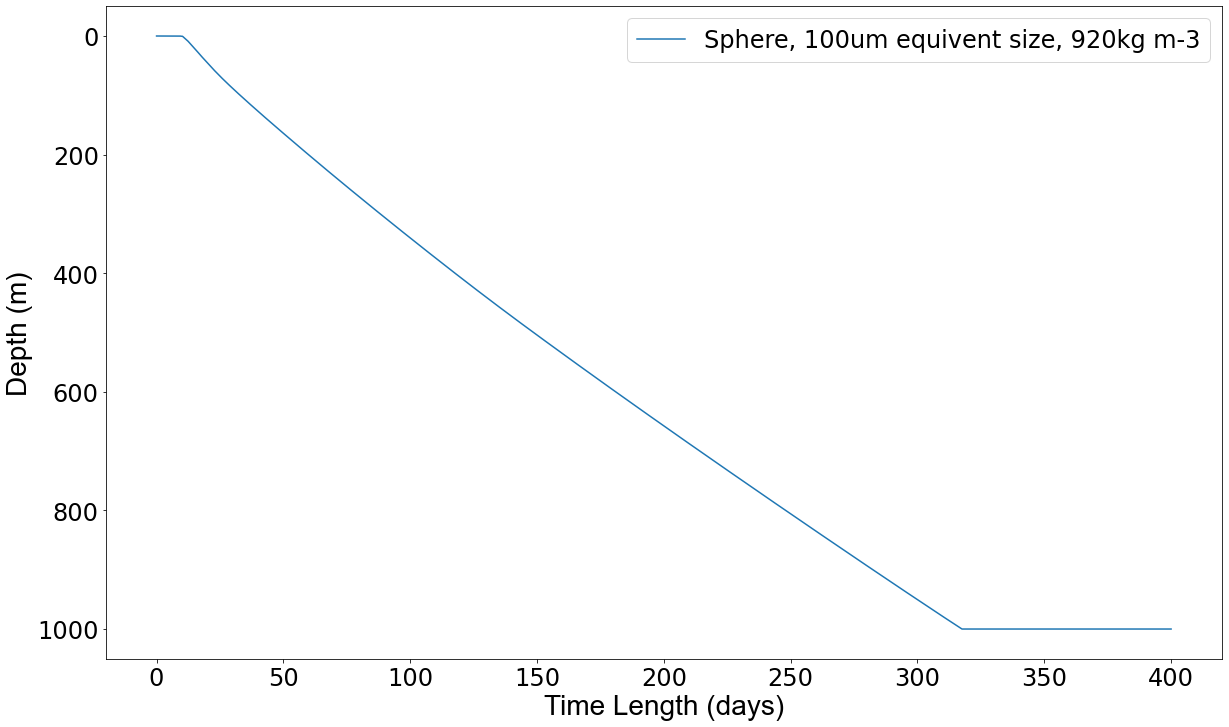

In [170]:
plt.figure(figsize=(20,12))
time_scale = 20000
plt.plot(dep_record1[0:time_scale,0],dep_record1[0:time_scale,1])
#plt.plot(dep_record2[0:time_scale,0],dep_record2[0:time_scale,1])
#plt.plot(dep_record3[0:time_scale,0],dep_record3[0:time_scale,1])
plt.gca().invert_yaxis()
font1 = {'family': 'Arial',
         'weight': 'normal',
         'size': 28,
         }
plt.title('',font1)
plt.xlabel('Time Length (days)',font1)
plt.ylabel('Depth (m)',font1)
plt.tick_params(labelsize=24)
plt.legend(labels=["Sphere, 100um equivent size, 920kg m-3",
                   "Film, 100um equivent size, 10nm thickness, 920kg m-3",
                   "Fiber, 100um equivent size, 1mm length, 920kg m-3"],loc="upper right",fontsize=24)  
plt.show()

In [70]:
dep_record1 = np.load(path1+'Sphere_Traj_1e-06_920_1.npy')
dep_record2 = np.load(path1+'Sphere_Traj_1e-06_940_1.npy')
dep_record3 = np.load(path1+'Sphere_Traj_1e-06_960_1.npy')
dep_record4 = np.load(path1+'Sphere_Traj_1e-06_980_1.npy')
dep_record5 = np.load(path1+'Sphere_Traj_1e-06_1000_1.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\暨南大学\\碳排放与碳中和\\Proposal\\Biofouling\\Paper\\Test Results\\Trajectory\\\\Sphere_Traj_1e-06_920_1.npy'

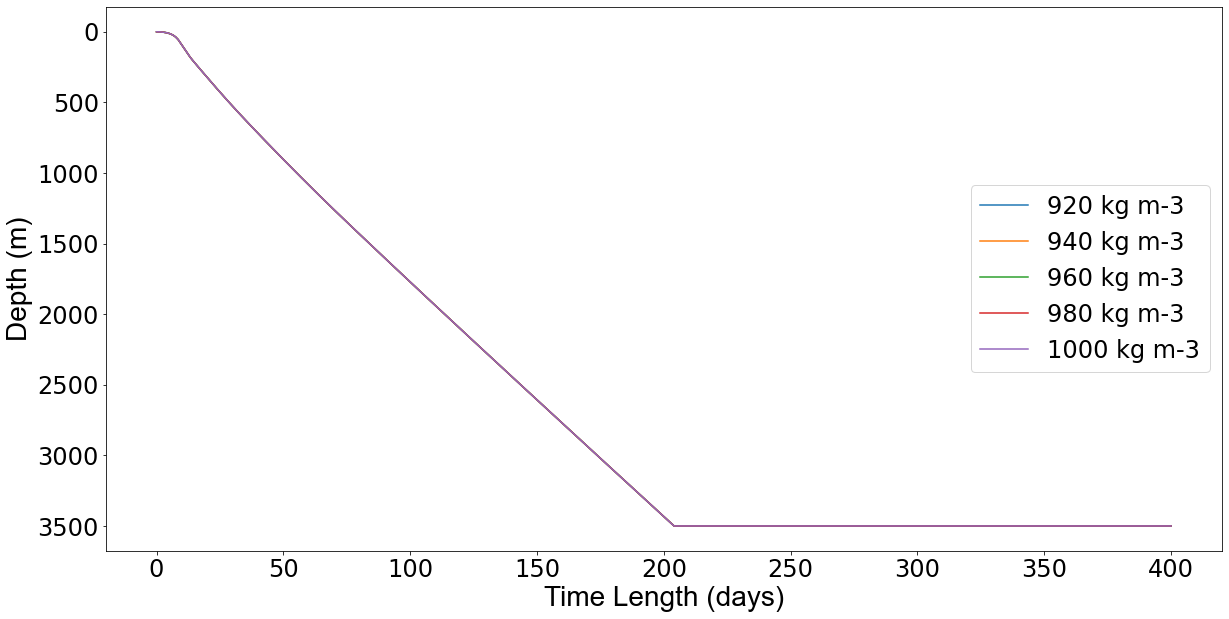

In [241]:
plt.figure(figsize=(20,10))
time_scale = 40000
plt.plot(dep_record1[0:time_scale,0],dep_record1[0:time_scale,1])
plt.plot(dep_record2[0:time_scale,0],dep_record2[0:time_scale,1])
plt.plot(dep_record3[0:time_scale,0],dep_record3[0:time_scale,1])
plt.plot(dep_record4[0:time_scale,0],dep_record4[0:time_scale,1])
plt.plot(dep_record5[0:time_scale,0],dep_record5[0:time_scale,1])
plt.gca().invert_yaxis()
font1 = {'family': 'Arial',
         'weight': 'normal',
         'size': 28,
         }
plt.title('',font1)
plt.xlabel('Time Length (days)',font1)
plt.ylabel('Depth (m)',font1)
plt.tick_params(labelsize=24)
plt.legend(labels=["920 kg m-3","940 kg m-3","960 kg m-3","980 kg m-3","1000 kg m-3"],loc="right",fontsize=24)  
plt.show()

In [34]:
Lat = float(Latitude[:-1])
den_A = 1380
V_A = 1e-15
m_A = 0.39
R_20 = 0.1
k = 1.0306e-013
Q_10 = 2
u_max = 1.85
alpha = 0.12
T_min = 0.2
T_opt = 26.7
T_max = 33.3
I_opt = 1.75392e13
t = 0.02
o_w = 0.2
o_p = 0.02
I_m = 1.2e08
bins = np.array([0.,10.,20.,30.,50.,75.,100.,125.,150.,200.,250.,300.,400.,500.,600.,700.,800.,900.,1000.,1100.,
                 1200.,1300.,1400.,1500.,1750.,2000.,2500.,3000.,3500.,4000.,4500.,5000.,5500.])
shear = 1.7e05
r_A = (3*V_A/(4*pi))**(1/3)
chl_a_bins = np.array([0,0.04,0.08,0.12,0.2,0.3,0.4,0.8,2.2,4])

In [66]:
num_mp = 3000
dep_record = []
result = []

for i in range(num_mp):
    n = random.random()
    phy_att = 0.25
    dep = 0
    W_t = 0
    m_b = 0
    #n = 0.6
    if n < 0.3:
        shape_type = 'fiber'
    elif n >= 0.3 and n < 0.6:
        shape_type = 'film'
    else:
        shape_type = 'sphere'
    r_pl = (exponential_rand(5.5)*1000)*0.000001*0.5
    l_pl = random.randrange(100,13000)*0.000001
    t_pl = random.randrange(10,50)*0.000001
    Ca_g = 0.5
    den_pl = random.randrange(920,1000)
    if shape_type == 'sphere':
        V_pl, S_pl = MP_sphere(r_pl)
        V_T = V_pl
        shape_f = random.randrange(9,10)*0.1  
    elif shape_type == 'fiber':
        r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
        V_pl, S_pl = MP_fiber(r_fiber,l_pl)
        V_T = V_pl
        shape_f = shape_factor_fiber(V_T,l_pl)   
    elif shape_type == 'film':
        r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
        V_pl, S_pl = MP_film(r_film,t_pl)
        V_T = V_pl
        shape_f = shape_factor_film(V_T,r_film)  
    V_bf = 0
    V_M = 0
    d_ESD = ESD(V_pl)
    sign, posi_den, posi_sat, posi_temp, dep = position(dep,bins,Sea_den,sat.data,temp.data)
    w_v = water_viscosity(posi_temp,posi_sat)
    Beta_A = collision(d_ESD,posi_temp,k,r_A,w_v,W_t,shear)
    A = 0
    sign = 0
    t_total = 0
    if random.random() < 0.7:
        time_lenth = random.randrange(23,35)
    else:
        time_lenth = random.randrange(35,200)
    round_sim = int(time_lenth/t)
    t_ac = 0
    
    while sign == 0 and t_total < round_sim:
        sign, posi_den, posi_sat, posi_temp, dep = position(dep,bins,Sea_den,sat.data,temp.data)
        chl_a = position_chl_a(Latitude,Longtitude,Lat_bins,Lon_bins,dataset)
        if chl_a > 4:
            chl_a = 3.9
        Chl_a = Chloro_a(parameter_list, chl_a_bins, chl_a, dep)
        L_z, o_t = light_intensity(dep,Chl_a,o_w,o_p,t_ac,I_m,Lat)
        A_conc,C_conc = algae_c(Chl_a,posi_temp,L_z,V_A)
        A_g = algae_growth(L_z,u_max,I_opt,alpha,posi_temp,T_max,T_min,T_opt)
        w_v = water_viscosity(posi_temp,posi_sat)
        Beta_A = collision(d_ESD,posi_temp,k,r_A,w_v,W_t,shear)
        B_g = biofilm_growth(S_pl, A_g, A_conc, Beta_A, m_A, posi_temp, Q_10, R_20, A, phy_att)
        m_b, V_M = minal_volume(Ca_g,L_z,I_m,t,m_b,dep,V_A, A, S_pl)
        V_bf, A = bio_volume(B_g, V_A, t, A, S_pl)
        V_T = total_volume(V_M, V_bf, V_pl)
        m_pl = V_pl * den_pl
        m_bf = V_bf * den_A
        d_ESD = ESD(V_T)
        if shape_type == 'sphere':
            S_pl = 4*(((3*V_T/(4*pi))**(1/3))**2)*pi
        elif shape_type == 'fiber':
            shape_f = shape_factor_fiber(V_T,l_pl)
            S_pl = 2*pi*((V_T/l_pl*pi)**(1/2))*l_pl
        elif shape_type == 'film':
            shape_f = shape_factor_film(V_T,r_pl)
        g = local_g(Latitude,dep)
        in_den = mp_in_density(V_T,den_pl,den_A,m_b,V_bf,V_pl)
        Re, Wt, Cd = vertical_velocity(shape_f,posi_den*1000,in_den,g,d_ESD,w_v)
        mark = posi_den*1000*(1+0.02)
        if in_den < mark and int(dep) == 0:
            Wt = 0
        dep = dep + Wt*t
        posi_depth = max_depth_check(sat) - 1
        max_depth = bins[posi_depth]
        if dep < 0:
            dep = 0
            Wt = 0
        elif dep > max_depth:
            dep = max_depth
            Wt = 0
        elif np.isnan(dep):
            dep = dep_record[-1] + 0.001  
        t_ac = t_ac + t
        t_total = t_total + 1
        
    dep_record.append(dep)
    new_line = []
    new_line.append(shape_type)
    new_line.append(d_ESD)
    new_line.append(dep)
    result.append(new_line)
dep_record = np.array(dep_record)

In [67]:
path = r'E:\暨南大学\碳排放与碳中和\Proposal\Biofouling\Paper\Test Results\vertical_distribution\\'

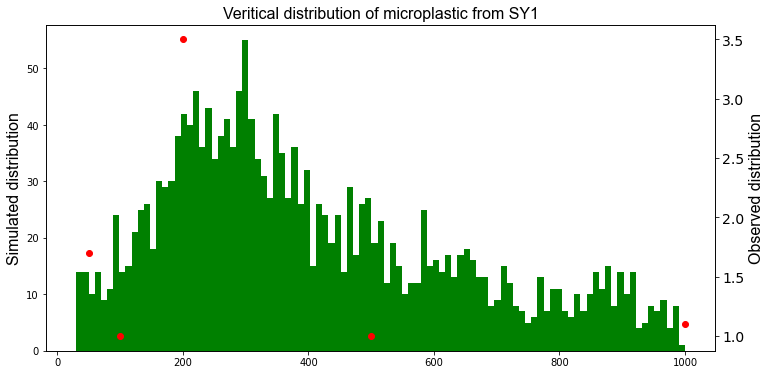

In [68]:
#Coordinate is 15.0N, 145.7E in west Pacific with duration from 10 to 100 days

#reference_dataset_SK1 = np.array([[2,50,400,1000],[2,1.2,1.5,1.2]])  #
#reference_dataset_SK2 = np.array([[2,50,200,260,300,500,1000,2000,3000],[1.3,0.9,1.1,0.8,1.5,0.5,0.8,0.5,0.3]])
#reference_dataset_SK3 = np.array([[2,50,100,500,1000,20 00],[0.3,1.5,0.3,0.7,0.2,0.2]])
reference_dataset_SY1 = np.array([[50,100,200,500,1000],[1.7,1,3.5,1,1.1]]) # 13.5N, 87.3E
#reference_dataset_SY2 = np.array([[50,100,200,500,1000],[1.7,1.7,2.3,1.2,0.5]]) # 0.1N, 87.3E
#reference_dataset_SY3 = np.array([[50,100,200,500,1000],[0.7,1.1,1.3,0.4,0.2]]) # 13.5S, 87.3E
bins_plot = np.linspace(30,1000,100)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 16,
         }
fig,ax1 = plt.subplots()
fig.set_size_inches(12, 6)
ax1.hist(dep_record,bins_plot,color='green')
ax1.set_ylabel('Simulated distribution',font2)
ax2 = ax1.twinx()
ax2.set_ylabel('Observed distribution',font2)
ax2.scatter(reference_dataset_SY1[0],reference_dataset_SY1[1],color='red')

plt.xlabel('Depth (m)',font2)
plt.title('Veritical distribution of microplastic from SY1',font2)
plt.tick_params(labelsize = 14)
plt.show()
np.save(path+'SY_1.npy',dep_record)

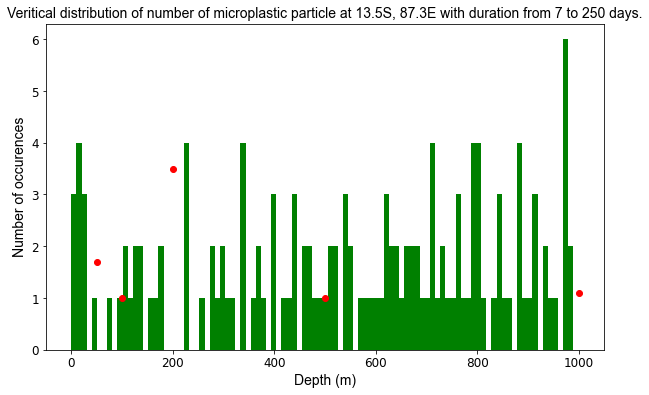

In [1303]:
bins = np.linspace(0,1000,100)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins,color='green')
plt.scatter(reference_dataset3[0],reference_dataset3[1],color='red')
#plt.plot(x_new,y_smooth,color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 13.5S, 87.3E with duration from 15 to 250 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

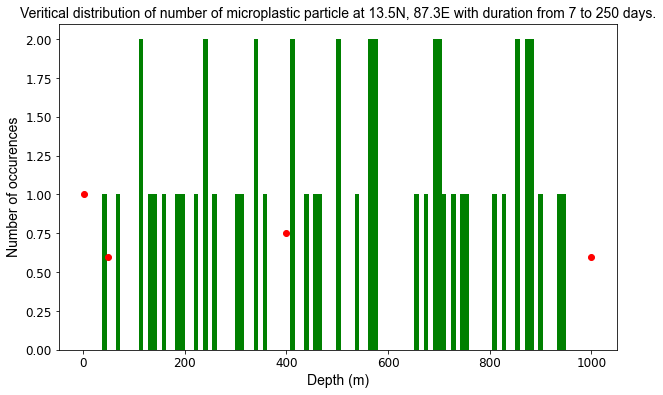

In [1266]:
bins = np.linspace(10,950,105)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins,color='green')
plt.scatter(reference_dataset2[0],reference_dataset2[1],color='red')
#plt.plot(x_new,y_smooth,color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 13.5N, 87.3E with duration from 7 to 250 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

In [ ]:
reference_dataset1 = np.array([[0,25,50,75,100,200,400,600,800,950],[3,4,3,1,5,12,7,9,3,2]])
from scipy.interpolate import make_interp_spline
x_new = np.linspace(min(reference_dataset1[0]),max(reference_dataset1[0]),50)
y_smooth = make_interp_spline(reference_dataset1[0], reference_dataset1[1])(x_new)

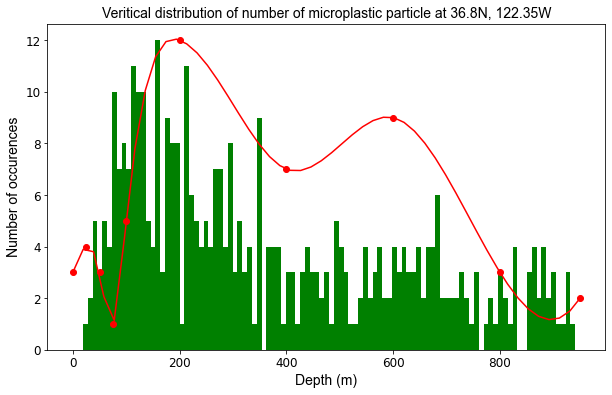

In [1200]:
bins = np.linspace(10,950,105)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins,color='green')
plt.scatter(reference_dataset1[0],reference_dataset1[1],color='red')
plt.plot(x_new,y_smooth,color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 36.8N, 122.35W',font2)
plt.tick_params(labelsize = 12)
plt.show()

In [899]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0

for i in range(len(result)):
    if result[i][2] == 1000:
        if result[i][0] == 'sphere':
            count1 = count1 + 1          
        elif result[i][0] == 'fiber':
            count2 = count2 + 1
        else:
            count3 = count3 + 1
    else:
        if result[i][0] == 'sphere':
            count4 = count4 + 1          
        elif result[i][0] == 'fiber':
            count5 = count5 + 1
        else:
            count6 = count6 + 1
print(count1,count2,count3)
print(count4,count5,count6)

4998 2523 1612
6 484 377


In [948]:
from scipy.interpolate import make_interp_spline
reference_dataset2 = np.array([[2,50,400,1000],[1,0.6,0.75,0.6]])
#x_new = np.linspace(min(reference_dataset2[0]),max(reference_dataset2[0]),50)
#y_smooth = make_interp_spline(reference_dataset2[0], reference_dataset2[1])(x_new)

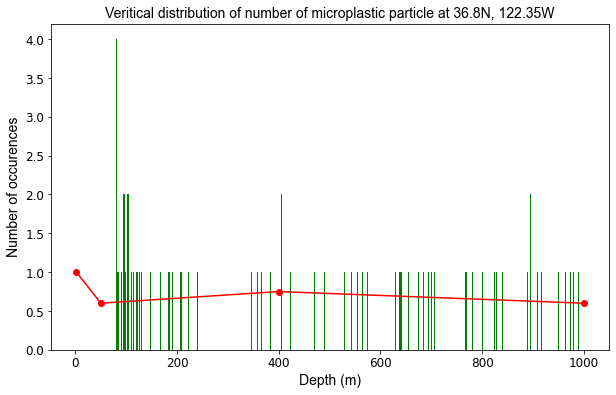

In [950]:
bins = np.linspace(min(dep_record),1000,1000)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins,color='green')
plt.scatter(reference_dataset2[0],reference_dataset2[1],color='red')
plt.plot(reference_dataset2[0],reference_dataset2[1],color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 36.8N, 122.35W',font2)
plt.tick_params(labelsize = 12)
plt.show()

In [906]:
result_plot = []
for i in range(len(result)):
    if result[i][2] == 1000:
        continue
    else:
        result_plot.append(result[i][1:3])

In [908]:
result_np = np.array(result_plot).astype(float)
result_np

array([[3.01438141e-04, 9.09425040e+02],
       [2.04669154e-04, 3.34593725e+02],
       [3.39432195e-04, 6.60865037e+02],
       ...,
       [6.69443390e-04, 2.61261416e+02],
       [2.19657833e-04, 2.78117271e+02],
       [7.16758581e-05, 6.62500589e+02]])

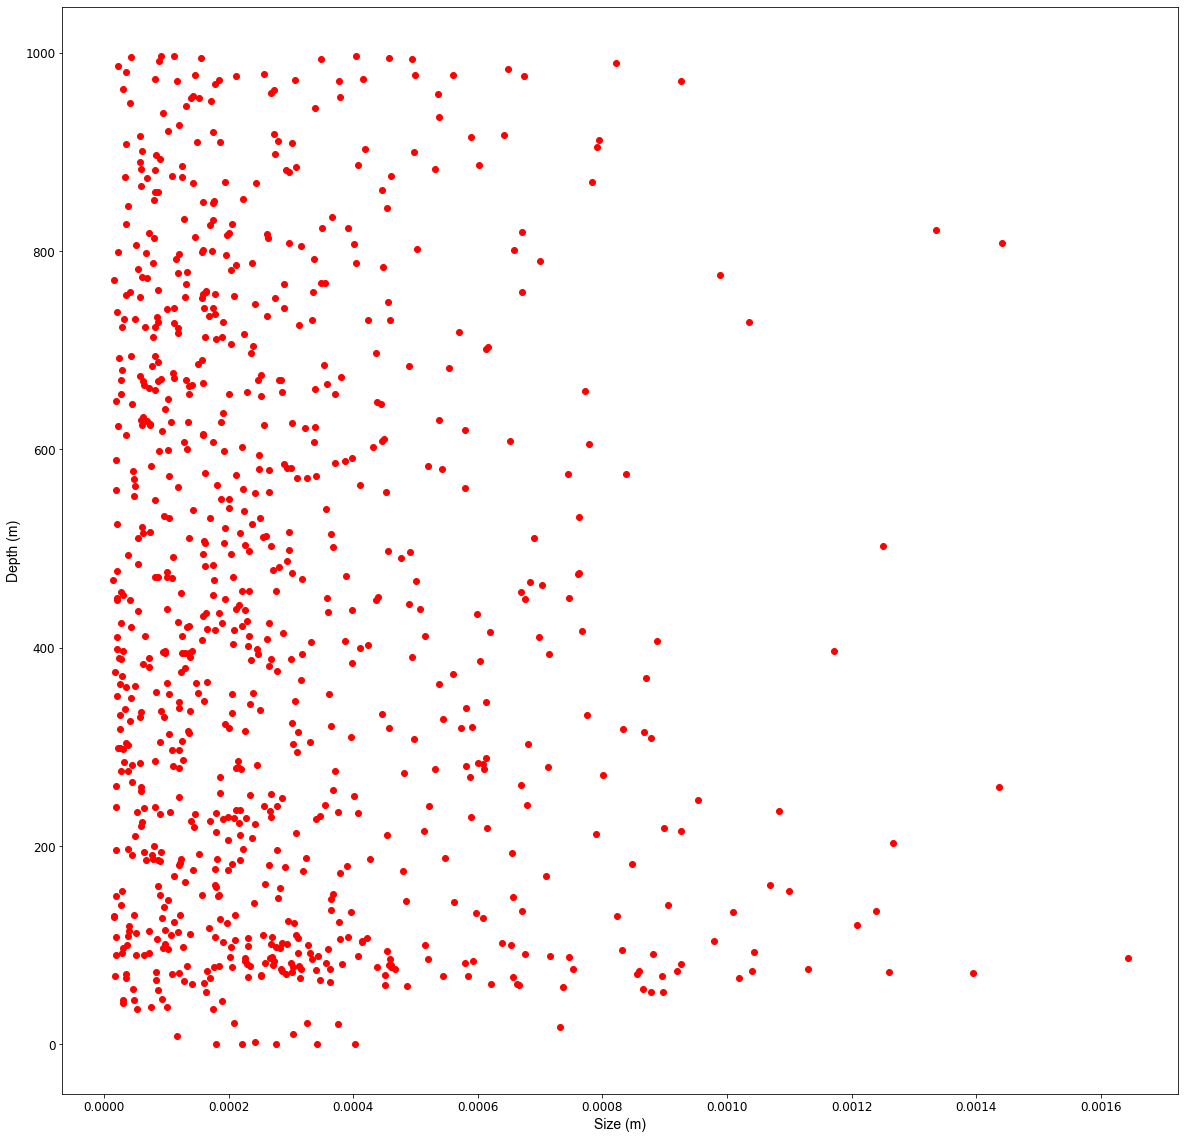

In [921]:
plt.figure(figsize=(20,20))
#plt.axes(xscale = "log",yscale = "log")
plt.scatter(result_np[:,0],result_np[:,1],color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Size (m)',font2)
plt.ylabel('Depth (m)',font2)
plt.tick_params(labelsize = 12)
plt.show()

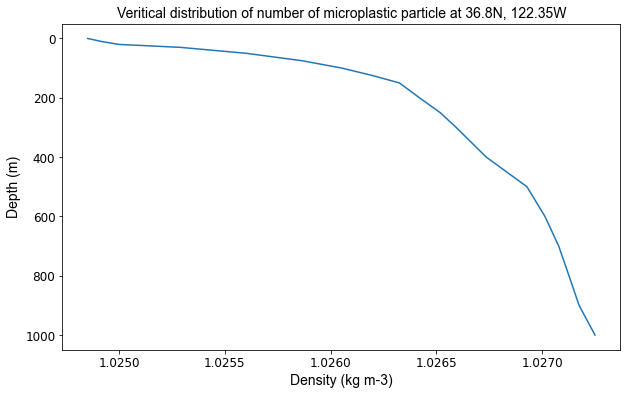

In [561]:
plt.figure(figsize=(10,6))
plt.plot(Sea_den,bins[0:len(Sea_den)])
#plt.plot(x_new,y_smooth,color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Density (kg m-3)',font2)
plt.ylabel('Depth (m)',font2)
plt.title('Veritical distribution of number of microplastic particle at 36.8N, 122.35W',font2)
plt.tick_params(labelsize = 12)
plt.gca().invert_yaxis()
plt.show()

In [563]:
reference_dataset2 = np.array([[2,50,400,1000],[2,1.2,1.5,1.2]])

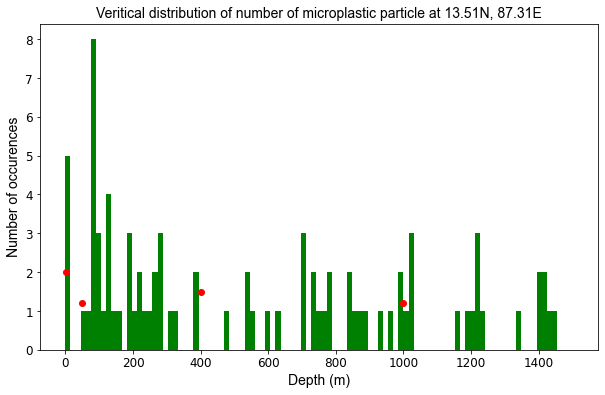

In [683]:
bins = np.linspace(min(dep_record),1500,300)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins,color='green')
plt.scatter(reference_dataset2[0],reference_dataset2[1],color='red')
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 13.51N, 87.31E',font2)
plt.tick_params(labelsize = 12)
plt.show()

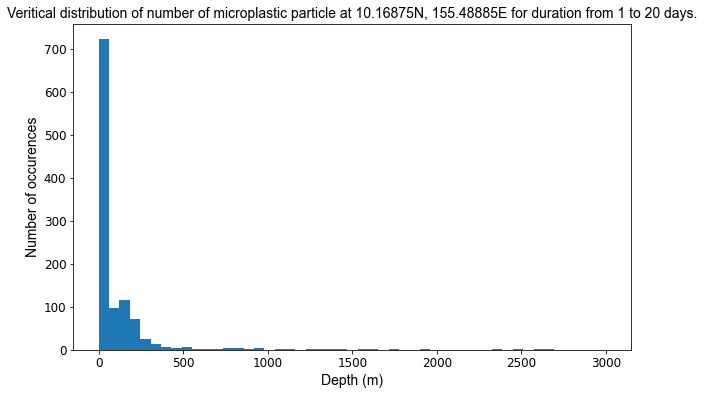

In [482]:
bins = np.linspace(min(dep_record),3000,50)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 10.16875N, 155.48885E for duration from 1 to 20 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

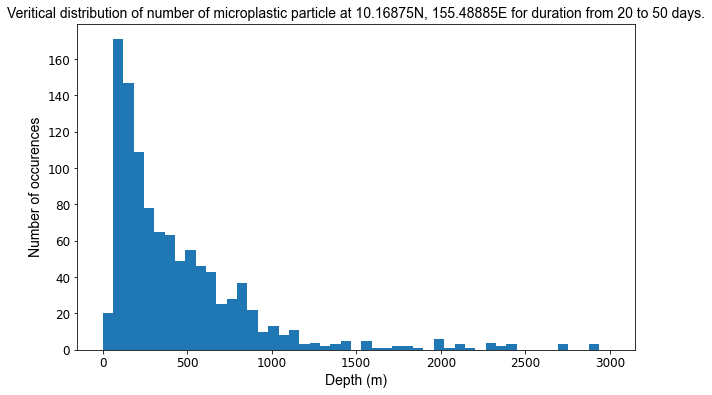

In [486]:
bins = np.linspace(min(dep_record),3000,50)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 10.16875N, 155.48885E for duration from 20 to 50 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

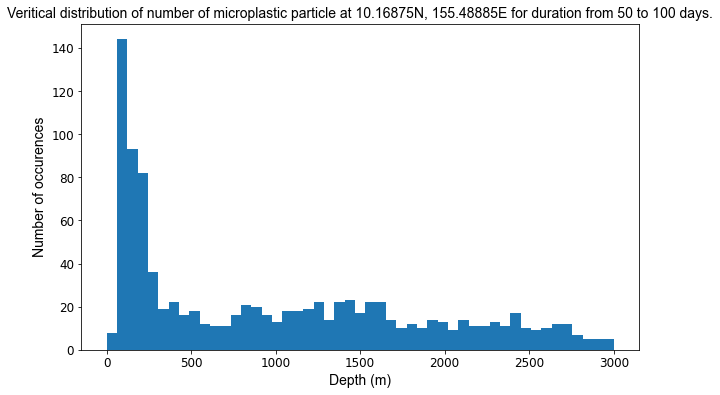

In [491]:
bins = np.linspace(min(dep_record),3000,50)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 10.16875N, 155.48885E for duration from 50 to 100 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

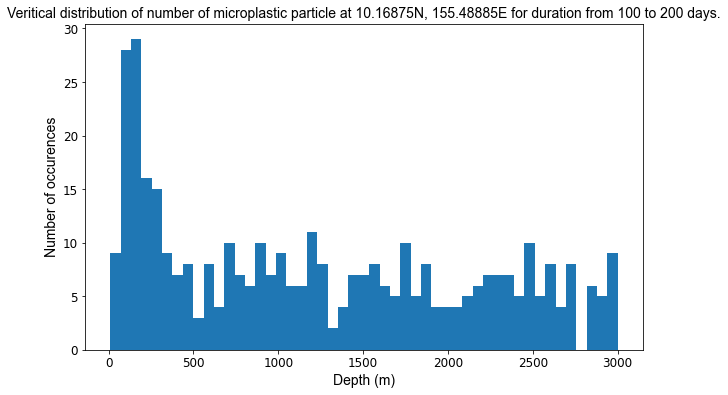

In [495]:
bins = np.linspace(min(dep_record),3000,50)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 10.16875N, 155.48885E for duration from 100 to 200 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

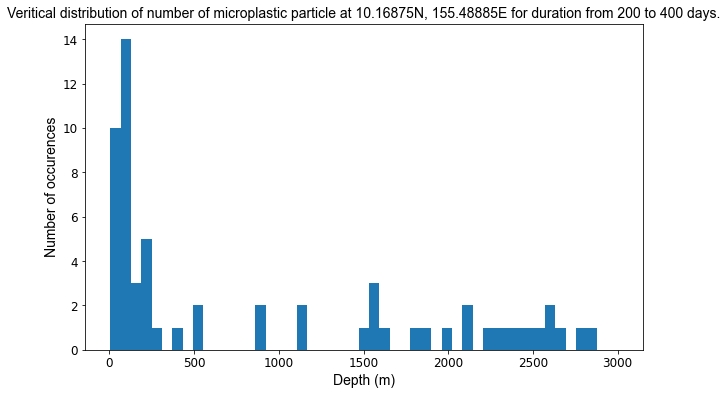

In [499]:
bins = np.linspace(min(dep_record),3000,50)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 10.16875N, 155.48885E for duration from 200 to 400 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

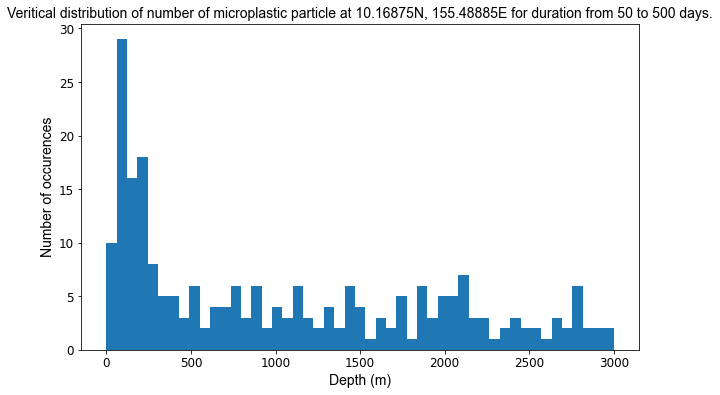

In [474]:
bins = np.linspace(min(dep_record),3000,50)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
font2 = {'family': 'Arial',
         'weight': 'normal',
         'size': 14,
         }
plt.xlabel('Depth (m)',font2)
plt.ylabel('Number of occurences',font2)
plt.title('Veritical distribution of number of microplastic particle at 10.16875N, 155.48885E for duration from 50 to 500 days.',font2)
plt.tick_params(labelsize = 12)
plt.show()

In [302]:
len(dep_record)

11000

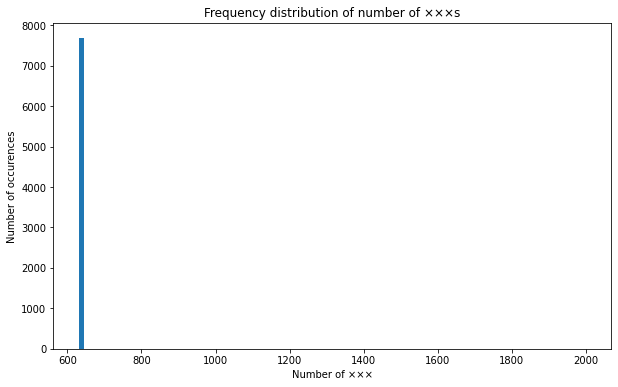

In [301]:
bins = np.linspace(min(dep_record),2000,100)
plt.figure(figsize=(10,6))
plt.hist(dep_record,bins)
plt.xlabel('Number of ×××')
plt.ylabel('Number of occurences')
plt.title('Frequency distribution of number of ×××s')
plt.show()

In [11]:
# Data import
url = 'F:\RTOFS\Original_data\\' + date + '_rtofs_glo_3dz_n024_daily_3ztio.nc'
file = netCDF4.Dataset(url)
lat  = file.variables['Latitude'][:]
lon  = file.variables['Longitude'][:]
dep = file.variables['Depth'][:]
temp = file.variables['temperature'][0,:,:,:]
file.close()

In [8]:
# Data import
url = 'F:\RTOFS\Original_data\\' + date + '_rtofs_glo_3dz_n024_daily_3zsio.nc'
file = netCDF4.Dataset(url)
# Extract data from given location
sat = file.variables['salinity'][0,:,:,:]
file.close()

In [14]:
new_layer_1 = water_density(temp,sat/1000)

C:\Users\JePhyllis\Anaconda3\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [19]:
xmax = np.amax(new_layer_1,axis=0)
xmin = np.amin(new_layer_1,axis=0)
final_density_diff = xmax - xmin

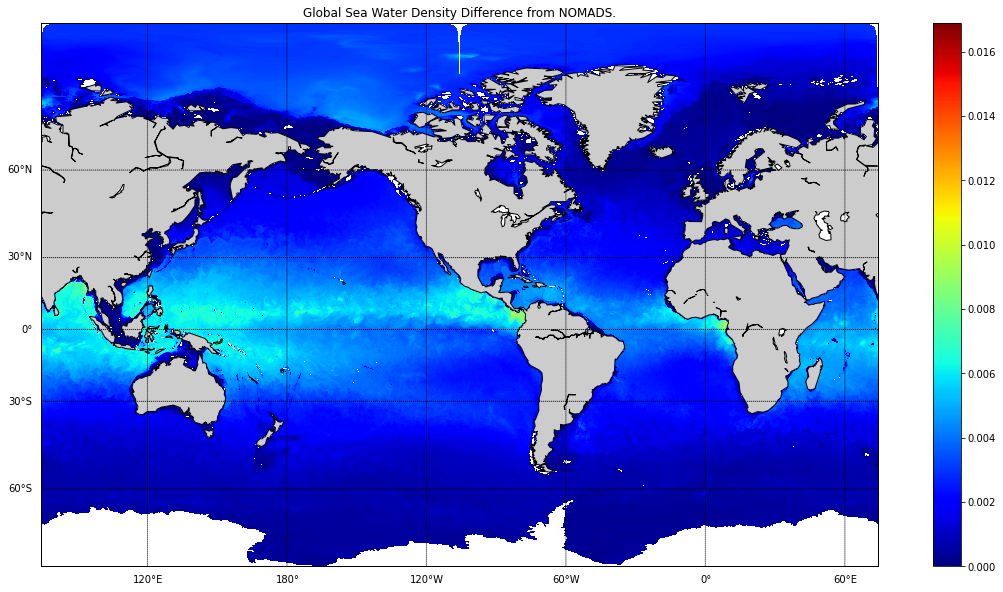

In [134]:
#lon = np.where(np.greater_equal(lon,500),np.nan,lon)
plt.figure(figsize=(20,10))
n = Basemap(projection='mill',lat_ts=10, \
  llcrnrlon=np.nanmin(lon),urcrnrlon=np.nanmax(lon),llcrnrlat=lat.min(),urcrnrlat=lat.max(), resolution='c')
x,y = n(lon,lat)
cs = n.pcolormesh(x,y,final_density_diff[1:,1:],shading='flat',cmap=plt.cm.jet)
n.drawcoastlines()
n.fillcontinents()
n.drawmapboundary()
n.drawparallels(np.arange(-90.,120.,30.), labels=[1,0,0,0])
n.drawmeridians(np.arange(-180.,180.,60.), labels=[0,0,0,1])
colorbar(cs)
plt.title('Global Sea Water Density Difference from NOMADS.')
plt.show()